# TP 2 de Video Processing

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
import numpy as np
from tqdm import tqdm
import yaml

In [113]:
PATH_TO_IMG_DIRECTORY = '../images/'
PATH_TO_CONFIG_FILE = '../config.yml'

In [114]:
def read_yaml(file_name):
    with open(file_name, 'r') as fichier:
        contenu = fichier.read()
        donnees = yaml.safe_load(contenu)
    return donnees

def write_yaml(data, nom_fichier):
    with open(nom_fichier, 'w') as fichier:
        contenu = yaml.dump(data, default_flow_style=False)
        fichier.write(contenu)

## **Question (A)**
Au TP1, vous avez réalisé de l’estimation de mouvement de type forward par blocs entre F1 et F2.

Procédez maintenant à de l’estimation backward par blocs entre F1 et F2.

In [3]:
def load_img_array(img_path :str) -> np.ndarray :
    img = Image.open(img_path)
    return np.asarray(img)

In [4]:
# Thank you Mister Medjkoune for those functions 

def display_image(array, now = True, vmin = None, vmax = None, title='',figsize=(20,10)):
    """Display 2D array as image"""
    fig, ax = plt.subplots(figsize =figsize)
    plt.imshow(array, cmap = plt.cm.gray, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    if now:
        plt.title(title)
        plt.show()
def display_images(images, lines = None, columns = None, indices = None, vmin = None, vmax = None):
    """Display a list of 2D arrays as images
    """
    if columns is None:
        if lines is None:
            columns = int(np.ceil(np.sqrt(len(images))))
        else:
            columns = int(np.ceil(float(len(images)) / lines))
    if lines is None:
        lines = int(np.ceil(float(len(images)) / columns))
    if indices is None:
        indices = range(1, len(images) + 1)
    for k in range(len(images)):
        if not images[k] is None:
            plt.subplot(lines, columns, indices[k])
            display_image(images[k], vmin = vmin, vmax = vmax, now = False)
    plt.show()

In [47]:
img_1_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'1.png')
img_2_file_path = os.path.join(PATH_TO_IMG_DIRECTORY,'2.png')

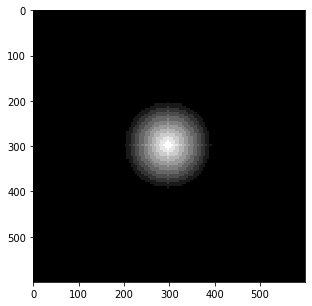

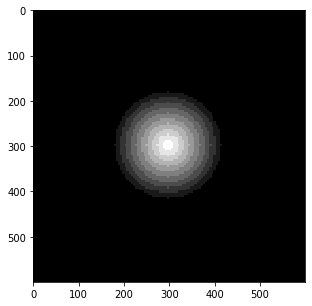

In [20]:
f1 = load_img_array(img_1_file_path)
f2 = load_img_array(img_2_file_path)
display_image(f1,figsize=(5,5))
display_image(f2,figsize=(5,5))

In [177]:
class BackWardEstimator():
    def __init__(self, frame_1_file_name :str, frame_2_file_name :str ,block_size:int = 25, window_size=20) -> None:
        """Classe dédiée pour l'estimation backward selon une taille de bloc et une taille de fenêtre.

        Args:
            frame_1_file_name (str): Chemin vers la frame 1
            frame_2_file_name (str): Chemin vers la frame 2
            block_size (int, optional): Rayon du bloc mis par défaut à 25
            window_size (int, optional): Taille de la fenêtre d'analyse misz par défaut à 20.
        """
        img1 = Image.open(frame_1_file_name)
        img2 = Image.open(frame_2_file_name)
        self.f2 = np.asarray(img2)
        self.f1 = np.asarray(img1)
        self.window_size = window_size
        self.block_size = block_size
        self.flow_vectors = []
        self.epsilon = None
        self.predicted_f2 = None
    
    def get_min_error_block(self,x :int,y:int,show_block = False) -> tuple:
        """Fonction qui minimise l'EDFD

        Args:
            `x` (int): Abscisse du centre du bloc.
            `y` (int): Ordonnée du centre du bloc.
            show_block (bool, optional): Option de debug.

        Returns:
            tuple: Coordonnées du point et du vecteur qui minimise l'EDFD.
        """
        height, width = self.f2.shape[:2]
        
        left_x_bound = max(x-self.block_size,0)
        right_x_bound = min(x+self.block_size,height-self.block_size)
        left_y_bound = max(y-self.block_size,0)
        right_y_bound = min(y+self.block_size,width-self.block_size)
        
        current_block = self.f2[x-self.block_size:x+self.block_size,y-self.block_size:y+self.block_size].astype(int)
        min_cost = float('inf')
        min_dist = float('inf')
        best_match = (0,0,0,0)
        for i in range(left_x_bound,right_x_bound):
            for j in range(left_y_bound,right_y_bound):
                prev_block = self.f1[i-self.block_size:i+self.block_size,j-self.block_size:j+self.block_size].astype(int)
                if current_block.shape != prev_block.shape :
                    continue
                cost = np.sum(np.abs(current_block - prev_block))
                dist = abs(x-i) + abs(y-j)
                if (cost  == min_cost and dist < min_dist):
                    best_match = (x,y,i-x,j-y)
                    min_dist = dist
                if(cost < min_cost):
                    min_cost = cost
                    best_match = (x,y,i-x,j-y)
    
        return best_match
    
    def back_ward_estimation(self) -> np.ndarray :
        """Méthode qui applique l'estimation de mouvement backward

        Returns:
            np.ndarray: Image avec le champs de vecteur backward.
        """
        height, width = self.f2.shape[:2]
        for x in tqdm(range(self.block_size,height-self.block_size+1,2*self.block_size)):
            for y in (range(self.block_size,width-self.block_size+1,2*self.block_size)):
                best_match = self.get_min_error_block(x,y)
                self.flow_vectors.append(best_match)
                
        img_to_display = np.copy(self.f2)
        for point in self.flow_vectors:
            x,y,dx,dy = point
            cv2.arrowedLine( img_to_display,(y,x), (int(dy+y),int(dx+x)), (255, 0, 0),1)
        
        print(f'Backward estimation by block wise method with {self.block_size} for block size and {self.window_size} for window size.')
        return img_to_display
    
    def display_backward_estimation(self)-> None:
        """Affiche l'estimation de mouvement backward.
        """
        img_to_display = self.back_ward_estimation()
        display_image(img_to_display,title='Backward Motion Estimation')
        
    def predict_f2(self,display=True) -> np.ndarray:
        """Prédiction de F2 en fonction de F1 et du champ de vecteur backward.
        Args:
            display (bool, optional): Précise s'il on affiche ou pas l'image prédite

        Returns:
            np.ndarray: Image à prédire
        """
        new_img = np.zeros(shape=self.f1.shape,dtype=np.uint8)
        # Pour chaque vecteur de l'estimation de mouvement backward on applique la procédure suivante:
        for vec in self.flow_vectors:
            x,y,dx,dy = vec
            f1_x = x+dx
            f1_y = y+dy 
            block_size = self.block_size
            # On récupère le block de f1 qui subit une translation lié à `vec`
            block_1 =  self.f1[f1_x-block_size:f1_x+block_size:,f1_y-block_size:f1_y+block_size]
            # On affecte le nouveau bloc dans l'image à prédire
            new_img[x-block_size:x+block_size,y-block_size:y+block_size] = block_1
        
        if(display):
            display_image(new_img,title='Reconstituted F2')
        self.predicted_f2 = new_img
        return new_img
    
    def get_predicted_f2(self)-> np.ndarray:
        """Renvoie la prédiction de F2
        Returns:
            np.ndarray: Prédiction de F2 par calculée par la backward estimation.
        """
        if (self.predicted_f2 is None):
            self.predict_f2(display=False)
        return self.predicted_f2
    
    def get_epsilon(self) -> np.ndarray:
        """Renvoie l'erreur epsilon = F2 - F2'

        Returns:
            np.ndarray: epsilon
        """
        
        return self.f2.astype(int) - self.get_predicted_f2().astype(int)
    
    def get_mse(self)->float:
        """Méthode qui calcule l'erreur moyenne quadratique(MSE).

        Returns:
            float: MSE
        """
        return np.mean(np.square(self.get_predicted_f2().astype(int) - self.f2.astype(int)))
    
    def reconstruct_f2(self,display:bool = True) -> np.ndarray:
        """Méthode qui consiste à recontruire F2 à partir de F1, du champs de vecteur et d'epsilon

        Returns:
            np.ndarray: F2 reconstruite
        """
        return 
    
    def __call__(self,display:bool = True) -> np.ndarray:
        """Lancment de l'estimation backward, elle enregistre les vecteurs de mouvement.

        Args:
            display (bool, optional): 

        Returns:
            np.ndarray: Image F2 avec les champs de vecteur
        """
        if (display):
            return self.display_backward_estimation()
        return self.back_ward_estimation()

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

Backward estimation by block wise method with 20 for block size and 10 for window size.


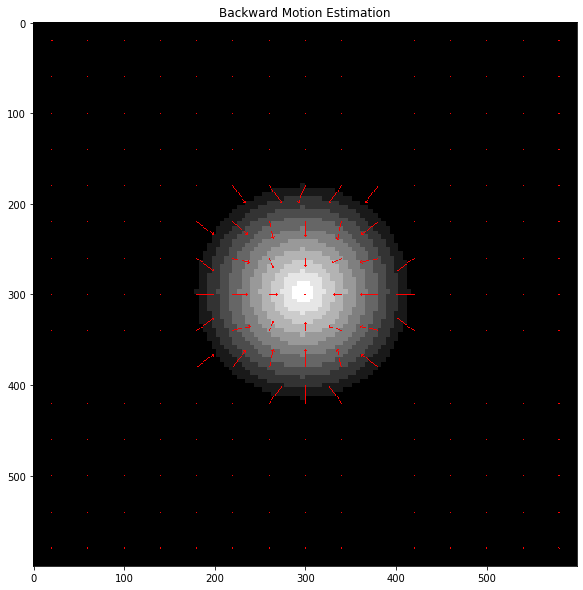

In [178]:
backward_estimator = BackWardEstimator(img_1_file_path,img_2_file_path,block_size=20,window_size=10)
backward_estimator()

|**Observations:** |**Interprétations:** | 
| :- | :- |
|On remarque que sur le fond noir les vecteurs sont nuls | Cela s'explique par une absence de mouvement entre les deux frames | 
|Au niveau du cercle les vecteur s'orientent tous vers le centre de l'image | Cela témoigne du rétrécissement du cercle de la frame 2 à la frame 1| 

## **Question (B)**
* Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ?
    
    On veut connaitre la frame de F2 à partir de F1, il convient donc de connaitre l'estimation de mouvement de F2 vers F1.

* Que se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)
    
    Nous aurions obtenu sûrement une estimation de mouvement incohérente, et du bruit dans l'image.

## **Question (C)**
Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de F1. Quelle est la MSE de reconstruction ?


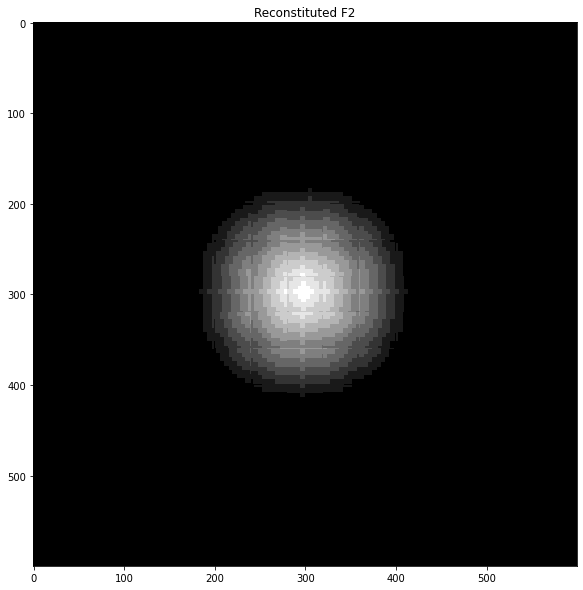

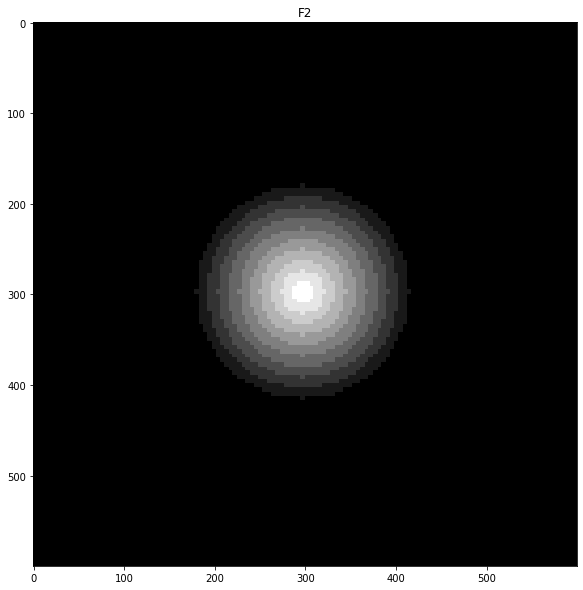

Mean squared error = 19.18123888888889


In [174]:
predicted_f2 = backward_estimator.predict_f2()
display_image(backward_estimator.f2, title='F2',figsize=(10,10))
mse = backward_estimator.get_mse()
print(f'Mean squared error = {mse}')


**Observations:**
- Le rayon des cercles lumineux pour F2 et F2 predite sont similaires.
- Le centre de F2 prédite possède une trace légèrement quadrillée au centre.
- L'affichage de la différence entre F2 et F2 predite montre tout de même du bruit au niveau de la reconstitution du cercle.
- Le fond noir reste constant.
- La MSE ne semble pas témoigner d'une grande différence entre F2 et F2 predite.

## **Question (D)**
Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données ”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la reconstruire de façon parfaite en compensation de mouvement ?


Il faut:
-  Le champ de vecteur de l'estimation backward
- L'erreur $\epsilon$ entre $F_1$ et $F_2$
- L'image $F_1$

In [176]:
backward_estimator.reconstruct_f2()

## **Question (E)**
Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE de reconstruction ?

## **Question (F)**
Expliquez quelles données on peut coder avec perte pour garder une
qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus.

## **Question (G)**
Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du point de vue de la minimisation ? et du point de vue du rendu final ? Montrez vos résultats en vous aidant du TP1.

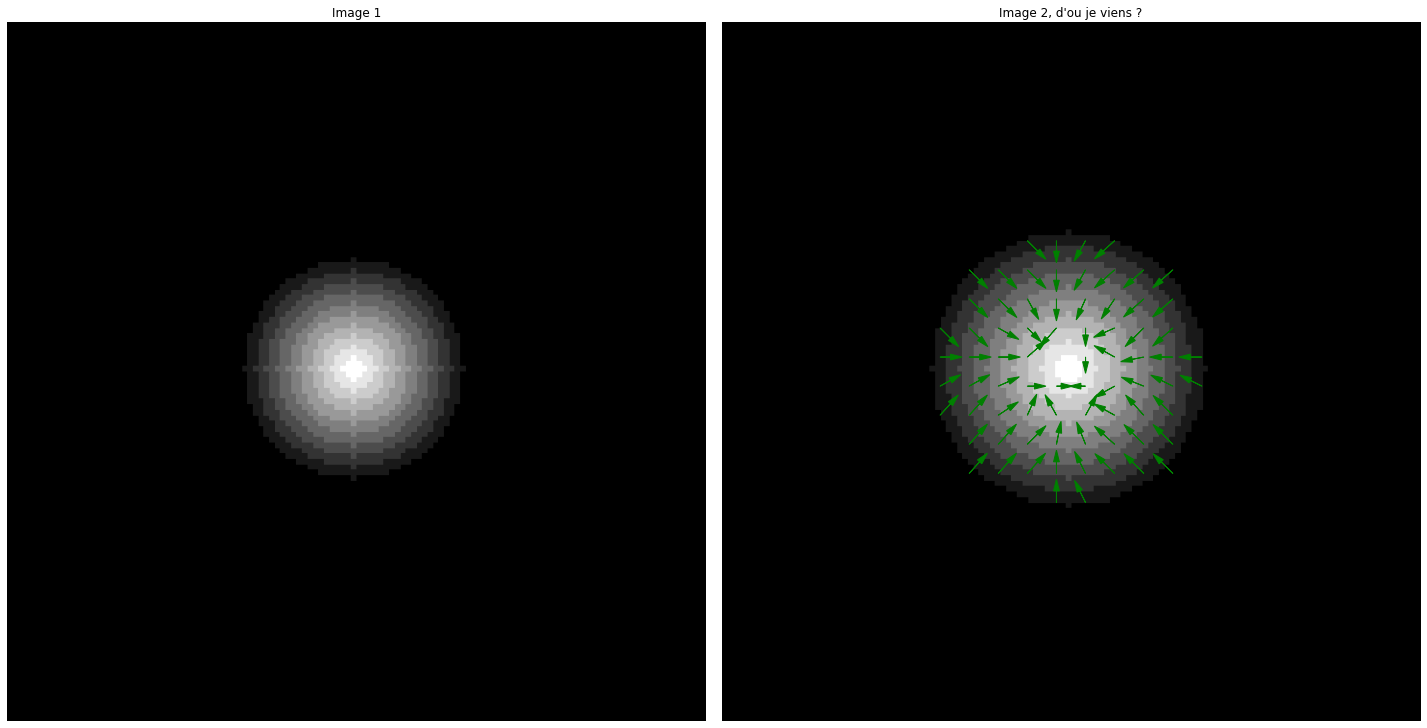

In [ ]:
def backward(file1, file2, block_size, search_radius):
    img1 = cv2.imread(file1, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(file2, cv2.IMREAD_GRAYSCALE)
    
    height = img1.shape[0]
    width = img1.shape[1]
    fig, axes = plt.subplots(1, 2,figsize=(20,10)) # 1 row, 2 columns
    assert (img1.shape == img2.shape)
    # Display img1 on the left
    axes[0].imshow(img1, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Image 1')

    # Work on img2 on the right
    axes[1].imshow(img2, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Image 2, d'ou je viens ?")
    vector_flow = []
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            source_block = img2[i:i+block_size, j:j+block_size] # on récupère le bloc de l'image source
            x_center = j + block_size//2 # on récupère le centre du bloc
            y_center = i + block_size//2 
            min_error = np.inf # initialisation de l'erreur minimale pour le bloc
            newx = 0 # initialisation du déplacement en x
            newy = 0 # initialisation du déplacement en y
            for k in range(-search_radius, search_radius):
                for l in range(-search_radius, search_radius): # k et l sont le centre du bloc cible
                    if y_center+k >= block_size and y_center+k < height - block_size and x_center+l >= block_size and x_center+l < width - block_size: # on vérifie que le bloc cible est bien dans l'image
                        x_top_left = x_center + l - block_size // 2 # on récupère le coin supérieur gauche du bloc cible
                        y_top_left = y_center + k - block_size // 2
                        target_block = img1[y_top_left:y_top_left+block_size, x_top_left:x_top_left+block_size]  # on récupère le bloc cible
                        error = np.sum(np.abs(source_block - target_block)) # calcul de l'erreur c'est à dire la somme des différences absolues entre les pixels des deux blocs
                        if error < min_error: # si l'erreur est plus petite que l'erreur minimale on la remplace et on garde le déplacement
                            min_error = error
                            newx = l
                            newy = k
                        if error == min_error: # si l'erreur est égale à l'erreur minimale on choisit le déplacement le plus petit
                            if np.abs(l) + np.abs(k) <= np.abs(newx) + np.abs(newy):
                                newx = l
                                newy = k
            if (newx != 0 or newy != 0):
                vector_flow.append((x_center,y_center,newx,newy))
                axes[1].arrow(x_center, y_center, newx, newy, head_width=5, head_length=10, fc='g', ec='g')
            square = ([j, j+block_size, j+block_size, j, j], [i, i, i+block_size, i+block_size, i])
            #axes[1].plot(*square, 'g')
    
    plt.tight_layout() # Ensure adequate spacing between subplots
    plt.show()
    return vector_flow
    
BLOCK_SIZE = 25
vector_flow = backward(img_1_file_path, img_2_file_path, BLOCK_SIZE, 10)
#backward('Images/LF021.jpg', 'Images/LF022.jpg', BLOCK_SIZE, 10)